# Forecasting GDP, Consumption Spending and Investment Expenditure with VAR

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Importing the dataset.  The dataset is taken from statsmodels https://www.statsmodels.org/dev/vector_ar.html. 

In [2]:
data = pd.read_csv("/content/drive/MyDrive/Time Series/VAR/macrodata.csv",index_col='Date',parse_dates=True)
data.head()

,realgdp,realcons,realinv
Date,,,
1959-03-31,2710.349,1707.4,286.898
1959-06-30,2778.801,1733.7,310.859
1959-09-30,2775.488,1751.8,289.226
1959-12-31,2785.204,1753.7,299.356
1960-03-31,2847.699,1770.5,331.722


In [3]:
data.index.freq = 'Q'

# Visualize the data

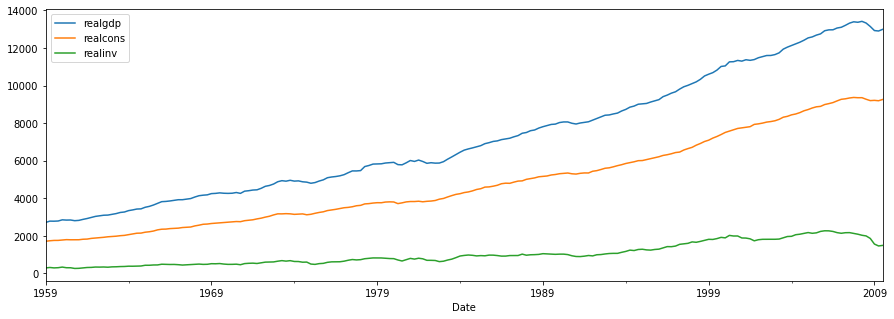

In [4]:
data.plot(figsize=(15,5))

# Split the data into train and test sets

In [5]:
nobs = 10

train = data[:-nobs]
test_df = data[-nobs:]

In [6]:
print(train.shape,test_df.shape)

(193, 3) (10, 3)


# Stationarity Check

In [7]:
from statsmodels.tsa.stattools import adfuller

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [8]:
def adfuller_test(ts,sig = 0.05,name='',verbose=False):
  result = adfuller(ts,autolag='AIC')
  output = {'test_statistic':round(result[0],3),'pvalue':round(result[1],3),'n_lags':round(result[2],3),'n_obs':result[3]}
  p_value = output['pvalue']
  def adjust(val,length=6): return str(val).ljust(length)

  print(f' Augmented Dickey-Fuller Test on "{name}"',"\n  ", '_'*47)
  print(f'Null Hypothesis: Data has unit root. Non-Stationary.')
  print(f'Significance Level = {sig}')
  print(f'Test  Statistic    = {output["test_statistic"]}')
  print(f'No. lags Chosen    ={output["n_lags"]}')

  for key,val in result[4].items():
    print(f'Critical value {adjust(key)}={round(val,2)}')

    if p_value <= sig:
      print(f"=> P-value={p_value}. Rejecting null hypothesis.")
      print(f"=>Series is stationary")
    else:
      print(f"=>p_value={p_value}.Weak evidence to reject the Null Hypothesis.")
      print(f"=> Series is Non-Stationary")

In [9]:
for name,column in train.iteritems():
  adfuller_test(column,name=column.name)
  print('\n')

 Augmented Dickey-Fuller Test on "realgdp" 
   _______________________________________________
Null Hypothesis: Data has unit root. Non-Stationary.
Significance Level = 0.05
Test  Statistic    = 2.616
No. lags Chosen    =2
Critical value 1%    =-3.47
=>p_value=0.999.Weak evidence to reject the Null Hypothesis.
=> Series is Non-Stationary
Critical value 5%    =-2.88
=>p_value=0.999.Weak evidence to reject the Null Hypothesis.
=> Series is Non-Stationary
Critical value 10%   =-2.57
=>p_value=0.999.Weak evidence to reject the Null Hypothesis.
=> Series is Non-Stationary


 Augmented Dickey-Fuller Test on "realcons" 
   _______________________________________________
Null Hypothesis: Data has unit root. Non-Stationary.
Significance Level = 0.05
Test  Statistic    = 3.189
No. lags Chosen    =3
Critical value 1%    =-3.47
=>p_value=1.0.Weak evidence to reject the Null Hypothesis.
=> Series is Non-Stationary
Critical value 5%    =-2.88
=>p_value=1.0.Weak evidence to reject the Null Hypothesis

# Transform the dataset

In [10]:
X_train = np.log(train)
train_dif = (X_train).diff().dropna()
train_dif.describe()

,realgdp,realcons,realinv
count,192.000000,192.000000,192.000000
mean,0.008206,0.008809,0.010448
std,0.008573,0.006747,0.045242
min,-0.020708,-0.022955,-0.193163
25%,0.003518,0.004868,-0.011771
50%,0.007922,0.008975,0.011437
75%,0.012997,0.013193,0.035325
max,0.038585,0.027733,0.122094


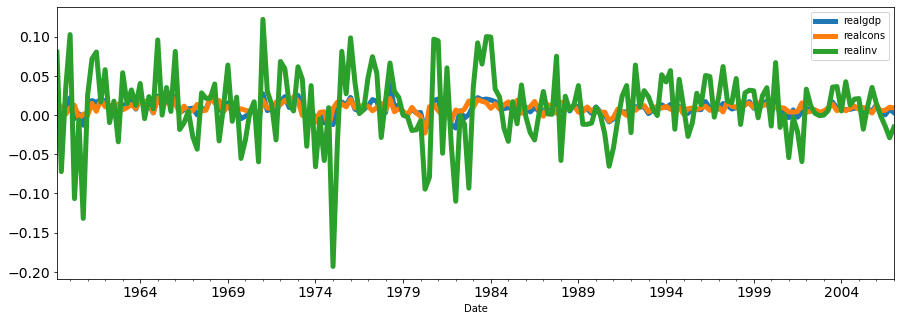

In [11]:
train_dif.plot(figsize=(15,5),linewidth=5,fontsize=14)
plt.show()

# Check for stationarity of the transformed data

In [12]:
for name,column in train_dif.iteritems():
  adfuller_test(column,name=column.name)
  print('\n')

 Augmented Dickey-Fuller Test on "realgdp" 
   _______________________________________________
Null Hypothesis: Data has unit root. Non-Stationary.
Significance Level = 0.05
Test  Statistic    = -7.131
No. lags Chosen    =1
Critical value 1%    =-3.47
=> P-value=0.0. Rejecting null hypothesis.
=>Series is stationary
Critical value 5%    =-2.88
=> P-value=0.0. Rejecting null hypothesis.
=>Series is stationary
Critical value 10%   =-2.57
=> P-value=0.0. Rejecting null hypothesis.
=>Series is stationary


 Augmented Dickey-Fuller Test on "realcons" 
   _______________________________________________
Null Hypothesis: Data has unit root. Non-Stationary.
Significance Level = 0.05
Test  Statistic    = -5.279
No. lags Chosen    =2
Critical value 1%    =-3.47
=> P-value=0.0. Rejecting null hypothesis.
=>Series is stationary
Critical value 5%    =-2.88
=> P-value=0.0. Rejecting null hypothesis.
=>Series is stationary
Critical value 10%   =-2.57
=> P-value=0.0. Rejecting null hypothesis.
=>Series

# Test for Causality

In [13]:
# Test for causality

from statsmodels.tsa.stattools import grangercausalitytests

maxlag = 12
test = 'ssr_chi2test'

def granger_causation_matrix(data,variables,test='ssr_chi2test',verbose=False):
    df = pd.DataFrame(np.zeros((len(variables),len(variables))),columns=variables,index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r,c]],maxlag=maxlag,verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y={r},X={c},P Values ={p_values}')
            min_p_value = np.min(p_values)
            df.loc[r,c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    
    return df

granger_causation_matrix(train_dif,variables = train_dif.columns)

,realgdp_x,realcons_x,realinv_x
realgdp_y,1.0000,0.0,0.0477
realcons_y,0.0365,1.0,0.0415
realinv_y,0.0000,0.0,1.0000


There is a strong evidence of causality among the variables at p < 0.05

# Selecting the lag Order for VAR modelling

In [14]:
from statsmodels.tsa.api import VAR

In [15]:
model = VAR(train_dif)
res = model.select_order(maxlags=10)
print(res.summary())

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -27.86      -27.81   7.958e-13      -27.84
1      -28.12*     -27.90*  6.158e-13*     -28.03*
2       -28.10      -27.73   6.276e-13      -27.95
3       -28.08      -27.55   6.382e-13      -27.87
4       -28.06      -27.38   6.505e-13      -27.78
5       -28.07      -27.23   6.449e-13      -27.73
6       -28.02      -27.02   6.774e-13      -27.62
7       -28.00      -26.84   6.956e-13      -27.53
8       -28.04      -26.72   6.703e-13      -27.50
9       -28.04      -26.56   6.678e-13      -27.44
10      -27.99      -26.36   7.026e-13      -27.33
--------------------------------------------------


var suggest lag 1 based on total support from all the candidates

In [16]:
model_fit = model.fit(1)
print(model_fit.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 12, Mar, 2022
Time:                     08:52:01
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -27.7863
Nobs:                     191.000    HQIC:                  -27.9078
Log likelihood:           1872.05    FPE:                6.97978e-13
AIC:                     -27.9906    Det(Omega_mle):     6.55901e-13
--------------------------------------------------------------------
Results for equation realgdp
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const               0.004167         0.000960            4.339           0.000
L1.realgdp         -0.354885         0.178548           -1.988           0.047
L1.realcons         0.711327         0.137370            5.178    

In [17]:
lag_order = model_fit.k_ar
print(lag_order)

1


In [18]:
input_data = train_dif.values[-lag_order:]
print(input_data)

[[ 0.00299856  0.00905317 -0.01552034]]


# Forecast VAR Model

In [19]:
pred = model_fit.forecast(y=input_data,steps=nobs)
pred = (pd.DataFrame(pred,index=test_df.index,columns=test_df.columns+'_pred'))
print(pred)

            realgdp_pred  realcons_pred  realinv_pred
Date                                                 
2007-06-30      0.008651       0.008415      0.016272
2007-09-30      0.008017       0.008827      0.009002
2007-12-31      0.008118       0.008746      0.010224
2008-03-31      0.008095       0.008757      0.009980
2008-06-30      0.008097       0.008754      0.010013
2008-09-30      0.008096       0.008754      0.010003
2008-12-31      0.008096       0.008754      0.010003
2009-03-31      0.008096       0.008754      0.010003
2009-06-30      0.008095       0.008754      0.010003
2009-09-30      0.008095       0.008754      0.010003


# Invert Transformation

In [20]:
def invert_transformation(train,pred_df):
  forecast = pred.copy()
  columns = X_train.columns

  for col in columns:
    forecast[str(col)+'_pred'] = train[col].iloc[-1]+ forecast[str(col) + '_pred'].cumsum()
  return forecast

output = invert_transformation(X_train,pred)
print(output)


            realgdp_pred  realcons_pred  realinv_pred
Date                                                 
2007-06-30      9.489011       9.142425      7.681374
2007-09-30      9.497028       9.151252      7.690375
2007-12-31      9.505146       9.159998      7.700600
2008-03-31      9.513241       9.168755      7.710579
2008-06-30      9.521338       9.177509      7.720592
2008-09-30      9.529434       9.186263      7.730595
2008-12-31      9.537529       9.195016      7.740599
2009-03-31      9.545625       9.203770      7.750602
2009-06-30      9.553720       9.212524      7.760605
2009-09-30      9.561816       9.221278      7.770607


In [21]:
output_original = np.exp(output)
print(output_original)

            realgdp_pred  realcons_pred  realinv_pred
Date                                                 
2007-06-30  13213.724617    9343.390943   2167.595549
2007-09-30  13320.085918    9426.230475   2187.195697
2007-12-31  13428.657960    9509.033638   2209.672491
2008-03-31  13537.800193    9592.671250   2231.834316
2008-06-30  13647.858742    9677.013050   2254.294020
2008-09-30  13758.796262    9762.097387   2276.957358
2008-12-31  13870.634343    9847.927844   2299.849201
2009-03-31  13983.380162    9934.512603   2322.969774
2009-06-30  14097.042066   10021.858427   2346.322535
2009-09-30  14211.627689   10109.972143   2369.909913


# Merge the test data with the predicted dataset

In [22]:
df_data = test_df.join(output_original)

In [23]:
df_data

,realgdp,realcons,realinv,realgdp_pred,realcons_pred,realinv_pred
Date,,,,,,
2007-06-30,13203.977,9291.5,2162.214,13213.724617,9343.390943,2167.595549
2007-09-30,13321.109,9335.6,2166.491,13320.085918,9426.230475,2187.195697
2007-12-31,13391.249,9363.6,2123.426,13428.657960,9509.033638,2209.672491
2008-03-31,13366.865,9349.6,2082.886,13537.800193,9592.671250,2231.834316
2008-06-30,13415.266,9351.0,2026.518,13647.858742,9677.013050,2254.294020
2008-09-30,13324.600,9267.7,1990.693,13758.796262,9762.097387,2276.957358
2008-12-31,13141.920,9195.3,1857.661,13870.634343,9847.927844,2299.849201
2009-03-31,12925.410,9209.2,1558.494,13983.380162,9934.512603,2322.969774
2009-06-30,12901.504,9189.0,1456.678,14097.042066,10021.858427,2346.322535


# Visualize the Forecasts

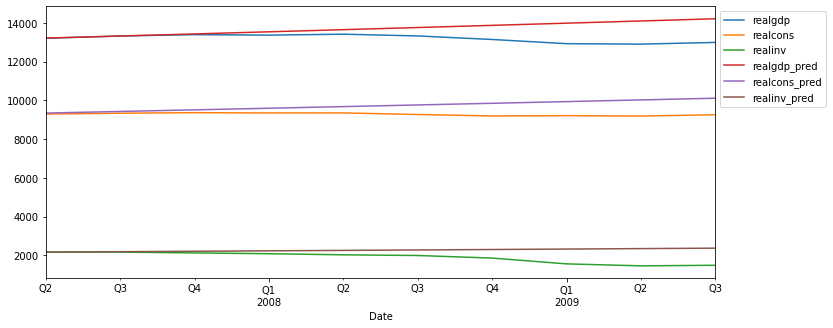

In [24]:
df_data.plot(figsize=(12,5),legend=True)
plt.legend(bbox_to_anchor =(1, 1))

# Evaluate the Forecast

In [25]:
df_data['GDP_error(%)'] = round(abs((df_data['realgdp']-df_data['realgdp_pred'])/df_data['realgdp'])*100,3)
df_data['RealInv(%)'] = round(abs((df_data['realinv']-df_data['realinv_pred'])/df_data['realinv'])*100,3)
df_data['RealCons(%)'] = round(abs((df_data['realcons']-df_data['realcons_pred'])/df_data['realcons'])*100,3)

In [26]:
df_data

,realgdp,realcons,realinv,realgdp_pred,realcons_pred,realinv_pred,GDP_error(%),RealInv(%),RealCons(%)
Date,,,,,,,,,
2007-06-30,13203.977,9291.5,2162.214,13213.724617,9343.390943,2167.595549,0.074,0.249,0.558
2007-09-30,13321.109,9335.6,2166.491,13320.085918,9426.230475,2187.195697,0.008,0.956,0.971
2007-12-31,13391.249,9363.6,2123.426,13428.657960,9509.033638,2209.672491,0.279,4.062,1.553
2008-03-31,13366.865,9349.6,2082.886,13537.800193,9592.671250,2231.834316,1.279,7.151,2.600
2008-06-30,13415.266,9351.0,2026.518,13647.858742,9677.013050,2254.294020,1.734,11.240,3.486
2008-09-30,13324.600,9267.7,1990.693,13758.796262,9762.097387,2276.957358,3.259,14.380,5.335
2008-12-31,13141.920,9195.3,1857.661,13870.634343,9847.927844,2299.849201,5.545,23.803,7.097
2009-03-31,12925.410,9209.2,1558.494,13983.380162,9934.512603,2322.969774,8.185,49.052,7.876
2009-06-30,12901.504,9189.0,1456.678,14097.042066,10021.858427,2346.322535,9.267,61.074,9.064


The forecast did pretty well in the 2nd and 3 quarters of 2007 with less than 1% error in the 3 variables.  The error began to increase beyond that.  However, GDP and Consumption spending did not record up to 10% error in all the forecasets.  The forecast error of investment was much larger than the other variables.